# TASK1 XLM

By Maha Usmani and Rania Siddiqui  


# Imports and setup


In [1]:
!pip install datasets

In [2]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 2.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import os
import shutil
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score

In [4]:
import gdown
import pandas as pd

# URLs of the datasets
dev_url = 'https://drive.google.com/uc?id=1SnCAPwCLKqgBQ5MJ01hX1sBwXXz0UpUQ'
test_url = 'https://drive.google.com/uc?id=1v6C__BiKOnzPuiMKjD_QBpKSsRgETlxg'
train_url = 'https://drive.google.com/uc?id=1BBBNaXyzlQq0CsNQocmsNMT1c58mwhYj'

# Downloading the datasets
gdown.download(dev_url, 'dev.json', quiet=False)
gdown.download(test_url, 'test.json', quiet=False)
gdown.download(train_url, 'train.json', quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1SnCAPwCLKqgBQ5MJ01hX1sBwXXz0UpUQ
To: /content/dev.json
100%|██████████| 1.42M/1.42M [00:00<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1v6C__BiKOnzPuiMKjD_QBpKSsRgETlxg
To: /content/test.json
100%|██████████| 2.14M/2.14M [00:00<00:00, 191MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BBBNaXyzlQq0CsNQocmsNMT1c58mwhYj
To: /content/train.json
100%|██████████| 9.40M/9.40M [00:00<00:00, 115MB/s]


'train.json'

# Loading the Training Dataset


In [5]:
df = pd.read_json('train.json',orient='index')
required_columns = ["id_EXIST", "lang", "tweet","labels_task1","labels_task2","labels_task3","split"]
df = df[required_columns]

# Loading the Validation Dataset

In [6]:
df_val = pd.read_json('dev.json',orient='index')
df_val = df_val[required_columns]

In [7]:
df_val

,id_EXIST,lang,tweet,labels_task1,labels_task2,labels_task3,split
300001,300001,es,@Fichinescu La comunidad gamer es un antro de ...,"[NO, YES, YES, NO, YES, NO]","[-, JUDGEMENTAL, JUDGEMENTAL, -, REPORTED, -]","[[-], [MISOGYNY-NON-SEXUAL-VIOLENCE], [MISOGYN...",DEV_ES
300002,300002,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,"[YES, YES, NO, YES, YES, YES]","[JUDGEMENTAL, REPORTED, -, JUDGEMENTAL, JUDGEM...","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",DEV_ES
300003,300003,es,@cosmicJunkBot lo digo cada pocos dias y lo re...,"[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_ES
300004,300004,es,Also mientras les decia eso la señalaba y deci...,"[NO, YES, YES, YES, YES, YES]","[-, REPORTED, REPORTED, REPORTED, JUDGEMENTAL,...","[[-], [SEXUAL-VIOLENCE], [SEXUAL-VIOLENCE], [S...",DEV_ES
300005,300005,es,"And all people killed, attacked, harassed by ...","[NO, YES, NO, NO, NO, NO]","[-, DIRECT, -, -, -, -]","[[-], [STEREOTYPING-DOMINANCE], [-], [-], [-],...",DEV_ES
...,...,...,...,...,...,...,...
400485,400485,en,@YesReallyAngel “Don’t wear a black bra with a...,"[YES, YES, YES, YES, YES, YES]","[DIRECT, DIRECT, JUDGEMENTAL, DIRECT, DIRECT, ...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION, SEX...",DEV_EN
400486,400486,en,""" get changed , you look like a prostitute . ""...","[YES, YES, YES, YES, NO, YES]","[DIRECT, REPORTED, REPORTED, REPORTED, -, DIRECT]","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",DEV_EN
400487,400487,en,made this top and my mom gave me the “you look...,"[YES, YES, YES, YES, YES, NO]","[JUDGEMENTAL, REPORTED, REPORTED, REPORTED, RE...","[[OBJECTIFICATION], [OBJECTIFICATION], [OBJECT...",DEV_EN
400488,400488,en,@DawnAnd91320913 I haven't seen anything that ...,"[YES, YES, YES, YES, YES, YES]","[DIRECT, DIRECT, DIRECT, DIRECT, DIRECT, DIRECT]","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",DEV_EN


## Loading Test Dataset

In [8]:
df_test = pd.read_json('/content/test.json',orient='index')

# Preproccessing the Dataset


In [9]:
def assign_majority_label(labels, num_annotators):
    if num_annotators == 1:labels = np.concatenate(labels)
    else:labels = np.array(labels).flatten()
    counts = pd.Series(labels).value_counts()
    filtered_counts = counts[counts > num_annotators]
    if len(filtered_counts.index) == 1:
        return filtered_counts.index[0]
    elif len(filtered_counts.index) > 1:
        return filtered_counts.index.tolist()
    else:
        return None

In [10]:
def transform(x):
    if x == "YES":return 1
    return 0


In [11]:
labels1 = ["YES","NO"]
def calculate_soft_labels_1(label):
    d = {label:0 for label in labels1}
    for i in label:
        d[i] = d.get(i, 0) + 1
    return softmax(d)


In [12]:
df["hard_label1"] = df["labels_task1"].apply(lambda x: assign_majority_label(x, 3))
df["hard_label1"] = df["hard_label1"].apply(transform)

df_val["hard_label1"] = df_val["labels_task1"].apply(lambda x: assign_majority_label(x, 3))
df_val["hard_label1"] = df_val["hard_label1"].apply(transform)


test_dataset1 = df_test[["tweet"]]
train_dataset_hard1 = df[["tweet", "hard_label1"]]

val_dataset_hard1 = df_val[["tweet", "hard_label1"]]

In [16]:

def tokenize_function(example):
    return tokenizer(
        example["tweet"],
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )

# XLM

In [ ]:
from datasets import Dataset

In [ ]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, TrainingArguments
model_name = "xlm-roberta-base"
chkpt = "/content/checkpointsxlm/checkpoint-5190"
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
tokenized_train = Dataset.from_pandas(train_dataset_hard1).map(tokenize_function, batched=True)
tokenized_validation = Dataset.from_pandas(val_dataset_hard1).map(tokenize_function, batched=True)
tokenized_test = Dataset.from_pandas(test_dataset1).map(tokenize_function, batched=True)

Map:   0%|          | 0/6920 [00:00<?, ? examples/s]

Map:   0%|          | 0/1038 [00:00<?, ? examples/s]

Map:   0%|          | 0/2076 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets = tokenized_train.rename_column("hard_label1", "labels")
tokenized_datasets_train = tokenized_datasets.remove_columns(["tweet", "__index_level_0__"])
tokenized_datasets_train.set_format("torch")


tokenized_datasets = tokenized_validation.rename_column("hard_label1", "labels")
tokenized_datasets_val = tokenized_datasets.remove_columns(["tweet", "__index_level_0__"])
tokenized_datasets_val .set_format("torch")

tokenized_test = tokenized_test.remove_columns(["tweet"])
tokenized_test.set_format("torch")

In [ ]:
from transformers import Trainer
import torch
torch.cuda.empty_cache()

training_args = TrainingArguments(
    output_dir="/content/checkpointsxlm",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    learning_rate=2e-05,
    weight_decay=0.0048,
    warmup_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch"
)


torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset= tokenized_datasets_val
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.633600,0.580426
2,0.590100,0.825995
3,0.514800,0.799453


TrainOutput(global_step=5190, training_loss=0.5794843317226638, metrics={'train_runtime': 2495.5429, 'train_samples_per_second': 8.319, 'train_steps_per_second': 2.08, 'total_flos': 5462185509273600.0, 'train_loss': 0.5794843317226638, 'epoch': 3.0})

# Plotting the graph

In [ ]:
training_loss = [i["loss"] for i in trainer.state.log_history[:-1:2]]
val_loss = [i["eval_loss"] for i in trainer.state.log_history[1::2]]

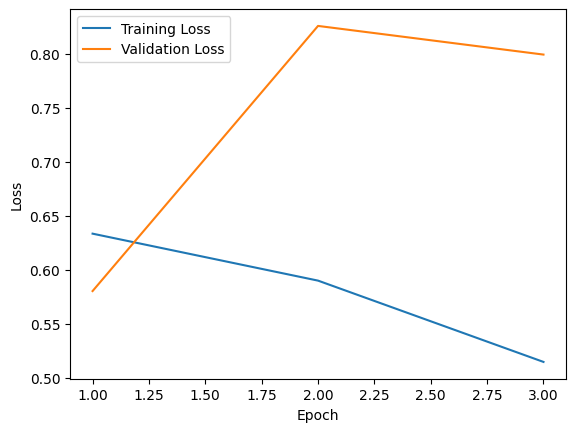

In [ ]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3], training_loss, label='Training Loss')
plt.plot([1, 2, 3], val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Predictions

In [ ]:
predictions_train, labels, metrics = trainer.predict(tokenized_datasets_train, metric_key_prefix="predict")
output_train = np.argmax(predictions_train, axis=1)

In [ ]:
predictions, labels, metrics = trainer.predict(tokenized_datasets_val, metric_key_prefix="predict")
predictions_sigmoid = torch.sigmoid(torch.from_numpy(predictions))
output = np.argmax(predictions, axis=1)

In [ ]:
output_train

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
labels = train_dataset_hard1["hard_label1"]
n = len(labels)
baseline_maj = [0 for i in range(n)]
baseline_min = [1 for i in range(n)]

print("Scores on Train Set")
f1 = f1_score(labels, baseline_maj)
accuracy = accuracy_score(labels, baseline_maj)
print("F1 Score of Basleine 1:", f1)
print("Accuracy of Baseline 1:", accuracy)

f1 = f1_score(labels, baseline_min)
accuracy = accuracy_score(labels, baseline_min)
print("F1 Score of Basleine 2:", f1)
print("Accuracy of Baseline 2:", accuracy)

f1 = f1_score(labels, output_train)
accuracy = accuracy_score(labels, output_train)
print("F1 Score of our model:", f1)
print("Accuracy of our model:", accuracy)

Scores on Train Set
F1 Score of Basleine 1: 0.0
Accuracy of Baseline 1: 0.6102601156069364
F1 Score of Basleine 2: 0.5608817718623271
Accuracy of Baseline 2: 0.38973988439306356
F1 Score of our model: 0.8772874058127018
Accuracy of our model: 0.9011560693641618


In [ ]:
from sklearn.metrics import f1_score, accuracy_score
labels = val_dataset_hard1["hard_label1"]
n = len(labels)
baseline_maj = [0 for i in range(n)]
baseline_min = [1 for i in range(n)]

print("Scores on Dev Set")
f1 = f1_score(labels, baseline_maj)
accuracy = accuracy_score(labels, baseline_maj)
print("F1 Score of Basleine 1:", f1)
print("Accuracy of Baseline 1:", accuracy)

f1 = f1_score(labels, baseline_min)
accuracy = accuracy_score(labels, baseline_min)
print("F1 Score of Basleine 2:", f1)
print("Accuracy of Baseline 2:", accuracy)

f1 = f1_score(labels, output)
accuracy = accuracy_score(labels, output)
print("F1 Score of our model:", f1)
print("Accuracy of our model:", accuracy)

Scores on Dev Set
F1 Score of Basleine 1: 0.0
Accuracy of Baseline 1: 0.5616570327552987
F1 Score of Basleine 2: 0.6095110515740121
Accuracy of Baseline 2: 0.43834296724470134
F1 Score of our model: 0.7657266811279827
Accuracy of our model: 0.791907514450867


### Output File

Output file on test set

In [ ]:
import json

In [ ]:
predictions2, labels, metrics = trainer.predict(tokenized_test, metric_key_prefix="predict")
output2 = np.argmax(predictions2, axis=1)
predictions2_sigmoid = torch.sigmoid(torch.from_numpy(predictions))

Epoch,Training Loss,Validation Loss
1,0.633700,0.546109
2,0.587900,0.630394
3,0.570200,0.733415


In [ ]:
output_test = []
for i in output2:
  if i == 1:
    output_test.append("YES")
  else:
    output_test.append("NO")

In [ ]:
count = 0
for i in output2:
  if i==0:
    count+=1
print("YES:",len(output2) - count, "\nNO: ",  count)

YES: 1084 
NO:  992


In [ ]:
count = 0
for i in output_test:
  if i=="NO":
    count+=1
print("YES:",len(output2) - count, "\nNO: ",  count)

YES: 1084 
NO:  992


In [ ]:
json_data = []

for i in range(len(tokenized_test['input_ids'])):
    json_object = {
        "id": str(tokenized_test['__index_level_0__'][i].item()),
        "value":  output_test[i],
         "test_case":"EXIST2024"
    }
    json_data.append(json_object)

with open('task1_hard_fmrs_2', 'w') as f:
    json.dump(json_data, f, indent=4)


# Bert

In [18]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
model_chkpt = "/content/checkpointsbert/checkpoint-3460"
model_name = "bert-base-multilingual-uncased"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 4)
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
Yo

In [14]:
from datasets import Dataset

In [19]:
tokenized_train = Dataset.from_pandas(train_dataset_hard1).map(tokenize_function, batched=True)
tokenized_validation = Dataset.from_pandas(val_dataset_hard1).map(tokenize_function, batched=True)
tokenized_test = Dataset.from_pandas(test_dataset1).map(tokenize_function, batched=True)

Map:   0%|          | 0/6920 [00:00<?, ? examples/s]

Map:   0%|          | 0/1038 [00:00<?, ? examples/s]

Map:   0%|          | 0/2076 [00:00<?, ? examples/s]

In [20]:
tokenized_datasets = tokenized_train.rename_column("hard_label1", "labels")
tokenized_datasets_train = tokenized_datasets.remove_columns(["tweet", "__index_level_0__"])
tokenized_datasets_train.set_format("torch")


tokenized_datasets = tokenized_validation.rename_column("hard_label1", "labels")
tokenized_datasets_val = tokenized_datasets.remove_columns(["tweet", "__index_level_0__"])
tokenized_datasets_val .set_format("torch")

tokenized_test = tokenized_test.remove_columns(["tweet"])
tokenized_test.set_format("torch")

### Train

In [21]:
from transformers import Trainer
import torch
torch.cuda.empty_cache()

training_args = TrainingArguments(
    output_dir="/content/checkpointsbert",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-05,
    weight_decay=0.0048,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch"
)


torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset= tokenized_datasets_val
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.593100,0.605090
2,0.531300,0.801261


Epoch,Training Loss,Validation Loss
1,0.593100,0.605090
2,0.531300,0.801261
3,0.384200,0.918123


TrainOutput(global_step=5190, training_loss=0.5028835054077854, metrics={'train_runtime': 2388.0897, 'train_samples_per_second': 8.693, 'train_steps_per_second': 2.173, 'total_flos': 5462283594792960.0, 'train_loss': 0.5028835054077854, 'epoch': 3.0})

### Predictions

In [22]:
predictions_train_bert, labels, metrics = trainer.predict(tokenized_datasets_train, metric_key_prefix="predict")
predictions_sigmoid = torch.sigmoid(torch.from_numpy(predictions_train_bert))
output_train_bert = np.argmax(predictions_sigmoid, axis=1)

In [24]:
predictions_val_bert, labels, metrics = trainer.predict(tokenized_datasets_val, metric_key_prefix="predict")
predictions_sigmoid = torch.sigmoid(torch.from_numpy(predictions_val_bert))
output_val_bert = np.argmax(predictions_sigmoid, axis=1)

In [ ]:
import os
import json
dev_gold = []
with open("/content/EXIST2024_dev_task1_gold_hard.json", 'r', encoding='utf-8') as f:
  data = json.load(f)
  print(len(data))
  for i in data:
    if i['value'] == "NO":dev_gold.append(0)
    else: dev_gold.append(1)
print(len(dev_gold))

934


For Train Set

In [23]:
from sklearn.metrics import f1_score, accuracy_score
labels = train_dataset_hard1["hard_label1"]
n = len(labels)
baseline_maj = [0 for i in range(n)]
baseline_min = [1 for i in range(n)]

print("Scores on Train Set for Bert")
f1 = f1_score(labels, baseline_maj)
accuracy = accuracy_score(labels, baseline_maj)
print("F1 Score of Basleine 1:", f1)
print("Accuracy of Baseline 1:", accuracy)

f1 = f1_score(labels, baseline_min)
accuracy = accuracy_score(labels, baseline_min)
print("F1 Score of Basleine 2:", f1)
print("Accuracy of Baseline 2:", accuracy)

f1 = f1_score(labels, output_train_bert)
accuracy = accuracy_score(labels, output_train_bert)
print("F1 Score of our model:", f1)
print("Accuracy of our model:", accuracy)

Scores on Train Set for Bert
F1 Score of Basleine 1: 0.0
Accuracy of Baseline 1: 0.6102601156069364
F1 Score of Basleine 2: 0.5608817718623271
Accuracy of Baseline 2: 0.38973988439306356
F1 Score of our model: 0.9289358600583091
Accuracy of our model: 0.9436416184971098


For Dev Set

In [25]:
from sklearn.metrics import f1_score, accuracy_score
labels = val_dataset_hard1["hard_label1"]
n = len(labels)
baseline_maj = [0 for i in range(n)]
baseline_min = [1 for i in range(n)]

print("Scores on Dev Set")
f1 = f1_score(labels, baseline_maj)
accuracy = accuracy_score(labels, baseline_maj)
print("F1 Score of Basleine 1:", f1)
print("Accuracy of Baseline 1:", accuracy)

f1 = f1_score(labels, baseline_min)
accuracy = accuracy_score(labels, baseline_min)
print("F1 Score of Basleine 2:", f1)
print("Accuracy of Baseline 2:", accuracy)

# f1 = f1_score(labels, dev_gold)
# accuracy = accuracy_score(labels, dev_gold)
# print("F1 Score of Dev Gold:", f1)
# print("Accuracy of Dev Gold:", accuracy)

f1 = f1_score(labels, output_val_bert)
accuracy = accuracy_score(labels, output_val_bert)
print("F1 Score of our model:", f1)
print("Accuracy of our model:", accuracy)

Scores on Dev Set
F1 Score of Basleine 1: 0.0
Accuracy of Baseline 1: 0.5616570327552987
F1 Score of Basleine 2: 0.6095110515740121
Accuracy of Baseline 2: 0.43834296724470134
F1 Score of our model: 0.7572383073496659
Accuracy of our model: 0.789980732177264


### Output File

In [ ]:
import json

In [ ]:
predictions_bert_test, labels, metrics = trainer.predict(tokenized_test, metric_key_prefix="predict")
predictions_bert_test = torch.sigmoid(torch.from_numpy(predictions_bert_test))
output_bert_test = np.argmax(predictions_bert_test, axis=1)

In [ ]:
output_bert_test_labels = []
for i in output_bert_test:
  if i == 1:
    output_bert_test_labels.append("YES")
  else:
    output_bert_test_labels.append("NO")

In [ ]:
json_data = []

for i in range(len(tokenized_test['input_ids'])):
    json_object = {
        "id": str(tokenized_test['__index_level_0__'][i].item()),
        "value":  output_bert_test_labels[i],
         "test_case":"EXIST2024"
    }
    json_data.append(json_object)

with open('task1_hard_fmrs_1', 'w') as f:
    json.dump(json_data, f, indent=4)


In [ ]:
count = 0
for i in output_bert_test_labels:
  if i=="NO":
    count+=1
print("YES:",len(output_bert_test) - count, "\nNO: ",  count)

YES: 816 
NO:  1260
